In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLPTemperature, MyMLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM, GMMTempWrapper
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian
from math import sqrt
from src.utils.data_utils import remove_mean
from math import sqrt, log

/opt/homebrew/envs/fkc_temp_annealing/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/envs/fkc_temp_annealing/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/homebrew/envs/fkc_temp_annealing/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/envs/fkc_temp_annealing/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/envs/fkc_temp_annealing/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/envs/fkc_temp_annealing/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/envs/fkc_temp_annealing/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### Target Distribution

In [316]:
dimensionality = 2
temperature = 1.0
annealed_temperature = 1 / 2
inverse_temperature = temperature / annealed_temperature  # beta in the paper

target = GMM(
    dimensionality=dimensionality,
    n_mixes=40,
    loc_scaling=40.0,
    log_var_scaling=2.0,
    device=device,
    should_unnormalize=True,
)

annealed_target = GMMTempWrapper(target, beta=int(inverse_temperature))

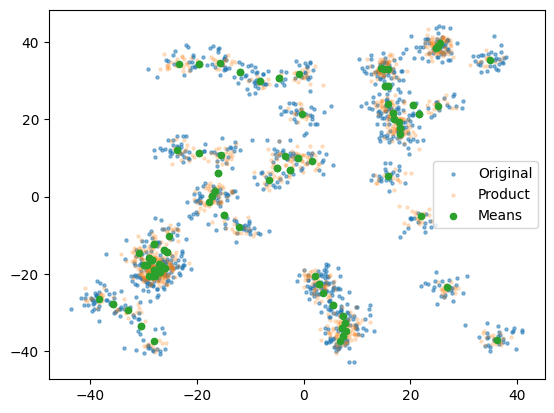

In [306]:
a = target.sample_test_set(1000)
b = annealed_target.sample_test_set(1000)

plt.scatter(
    a[:, 0].detach().cpu(), a[:, 1].detach().cpu(), label="Original", alpha=0.5, s=5
)
plt.scatter(
    b[:, 0].detach().cpu(), b[:, 1].detach().cpu(), label="Product", alpha=0.2, s=5
)
plt.scatter(
    annealed_target.gmm.locs[:, 0].cpu(),
    annealed_target.gmm.locs[:, 1].cpu(),
    label="Means",
    s=20,
)
plt.legend()

In [189]:
modes = torch.stack([target.gmm.locs[10], target.gmm.locs[20], target.gmm.locs[18]])

scales = torch.stack(
    [target.gmm.scale_trils[10], target.gmm.scale_trils[20], target.gmm.scale_trils[18]]
)


mix = torch.distributions.Categorical(logits=torch.ones(3).to(device))
com = torch.distributions.MultivariateNormal(
    modes, scale_tril=scales, validate_args=False
)
two_mode_dist = torch.distributions.MixtureSameFamily(
    mixture_distribution=mix, component_distribution=com, validate_args=False
)

In [190]:
one_mode_samples = torch.randn(1000, 2).to(device) * target.gmm.scale_trils[10][
    0, 0
] + target.gmm.locs[10][None, :].repeat(1000, 1)
init_samples = two_mode_dist.sample((1000,))

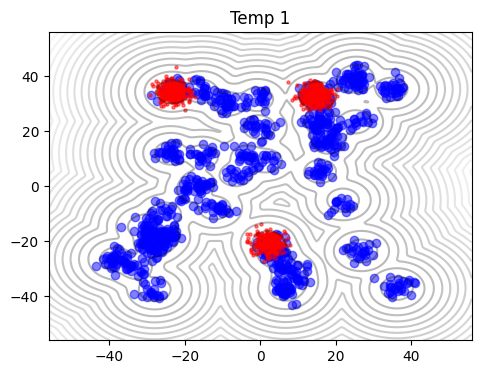

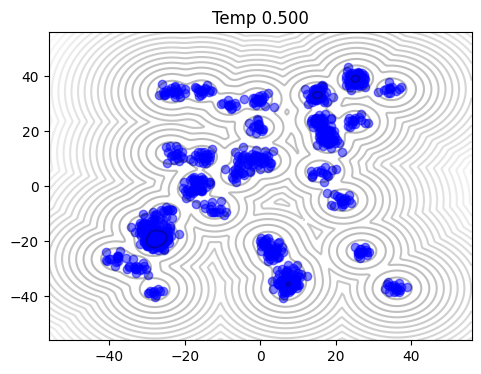

In [191]:
target.get_dataset_fig(a, title="Temp 1")
plt.scatter(
    init_samples[:, 0].detach().cpu(),
    init_samples[:, 1].detach().cpu(),
    c="r",
    label="One mode",
    alpha=0.5,
    s=5,
)
plt.show()

# title is annealed temperature up to 3 decimal points
annealed_target.get_dataset_fig(b, title=f"Temp {annealed_temperature:.3f}")
plt.show()

## Functions

In [192]:
from src.models.components.utils import rademacher, compute_laplacian_hutchinson
from src.models.components.utils import sample_cat_sys

In [193]:
def true_Ut(target, t, x, noise_schedule, ve=True):
    h_t = noise_schedule.h(t).to(device)
    mean_coeff = None
    if not ve:
        mean_coeff = noise_schedule.log_mean(t).to(device)
    target.gmm.convolve(
        h_t * (target.data_normalization_factor**2),
        t,
        var_exploding=ve,
        mean_coeff=mean_coeff,
    )
    logp = target(x)
    target.gmm.reset()
    return -logp


def true_nabla_Ut(target, t, x, noise_schedule, ve=True):
    nabla_Ut = torch.func.jacrev(true_Ut, argnums=2)(target, t, x, noise_schedule, ve)
    return nabla_Ut


def true_dUt_dt(target, t, x, noise_schedule, ve=True):
    dUt_dt = torch.func.jacrev(true_Ut, argnums=1)(target, t, x, noise_schedule, ve)
    return dUt_dt


# def compute_laplacian_true_exact(target, t, x, noise_schedule):
#     def compute_hessian(target, t, x):
#         return hessian(true_Ut, argnums=2)(target, t, x, noise_schedule)
#     hessian_matrix = torch.vmap(compute_hessian, in_dims=(None, 0, 0))(target, t, x)
#     laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
#     return laplacian


def compute_laplacian_true_exact(true_nabla_Ut, x):
    N, d = x.shape
    hessian_matrix = torch.zeros(N, d, d, device=x.device, dtype=x.dtype)

    # Compute the Hessian row-wise
    for i in range(d):  # ∂(∇U_t)_i / ∂x
        grad2 = torch.autograd.grad(
            true_nabla_Ut[:, i].sum(), x, retain_graph=True, create_graph=True
        )[0]
        hessian_matrix[:, i, :] = grad2  # i-th row
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian


# def compute_laplacian_true_exact(target, t, xt, noise_schedule):
#     def func_wrap(t, xt):
#         return true_Ut(
#             target, t.unsqueeze(0), xt.unsqueeze(0), noise_schedule
#         ).squeeze()

#     # Calculate the Hessian matrix of the model output with respect to the input
#     hessian_matrix = vmap(hessian(func_wrap, argnums=1))(t, xt)

#     # Calculate the Laplacian as the trace of the Hessian matrix
#     laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
#     return laplacian.detach()

In [194]:
def compute_laplacian_exact(model, t, xt, beta):
    def func_wrap(t, xt):
        return model(t.unsqueeze(0), xt.unsqueeze(0), beta).squeeze()

    # Calculate the Hessian matrix of the model output with respect to the input
    hessian_matrix = vmap(hessian(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    laplacian = hessian_matrix.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return laplacian.detach()


def compute_divergence(model, t, xt, beta):
    def func_wrap(t, xt):
        return model(t.unsqueeze(0), xt.unsqueeze(0), beta).squeeze()

    # Calculate the Hessian matrix of the model output with respect to the input
    nabla_bt = vmap(torch.func.jacrev(func_wrap, argnums=1))(t, xt)

    # Calculate the Laplacian as the trace of the Hessian matrix
    div_bt = nabla_bt.diagonal(offset=0, dim1=-2, dim2=-1).sum(dim=-1)
    return div_bt.detach()


def compute_laplacian(model, nabla_Ut, t, xt, beta, n_samples=1, exact=True):
    if exact:
        return compute_laplacian_exact(model, t, xt, beta)
    else:
        laplacian = 0
        for _ in range(n_samples):
            laplacian += compute_laplacian_hutchinson(nabla_Ut, t, xt)
        return laplacian / n_samples

### Integrators

In [311]:
def euler_maruyama_step(
    sde: VEReverseSDE,
    t: torch.Tensor,
    x: torch.Tensor,
    a: torch.tensor,
    dt: float,
    step: int,
    batch_size: int,
    diffusion_scale=1.0,
    resampling_interval=-1,
    inverse_temp=1.0,
):
    # Calculate drift and diffusion terms for num_eval_batches

    drift_Xt = torch.zeros_like(x)
    drift_At = torch.zeros_like(a)

    for i in range(x.shape[0] // batch_size):
        drift_Xt_i, drift_At_i = sde.f(
            t,
            x[i * batch_size : (i + 1) * batch_size],
            inverse_temp,
            resampling_interval,
        )
        drift_Xt[i * batch_size : (i + 1) * batch_size] = drift_Xt_i
        drift_At[i * batch_size : (i + 1) * batch_size] = drift_At_i

    # drift_Xt, drift_At = sde.f(t, x, resampling_interval)
    drift_Xt = drift_Xt * dt
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(x.device)
    diffusion = (
        diffusion_scale
        * sde.g(t)[:, None]
        * np.sqrt(dt)
        * torch.randn_like(x).to(x.device)
    )

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if (resampling_interval == -1 or (step + 1) % resampling_interval != 0) or t[
        0
    ] < 0.9:
        return x_next, a_next

    # resample based on the weights
    choice, _ = sample_cat_sys(x.shape[0], a_next)
    x_next = x_next[choice]
    a_next = torch.zeros_like(a_next)

    return x_next, a_next


def integrate_sde_coupled(
    sde,
    x0,
    t_span,
    dt,
    diffusion_scale,
    resampling_interval,
    inverse_temp,
    resample_at_end,
):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a = euler_maruyama_step(
                sde,
                1 - t,
                x,
                a,
                dt,
                step + 1,
                batch_size=x.shape[0],
                diffusion_scale=diffusion_scale,
                resampling_interval=resampling_interval,
                inverse_temp=inverse_temp,
            )
            samples.append(x)
            logweights.append(a)

        if resample_at_end:
            # resample at the last step:
            target_logprob = target(x)
            if t.dim() == 0:
                t = t * (torch.ones(x.shape[0])).to(x.device)
            model_energy = sde.model.forward_energy(1 - t, x, inverse_temp)
            logq_0 = -model_energy
            a_next = target_logprob - (logq_0) + a
            # a_next = torch.clamp(a_next, -10, 10)
            choice, _ = sample_cat_sys(x.shape[0], a_next)
            x = x[choice]
            logweights[-1] = a_next
            samples[-1] = x

    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(
    reverse_sde,
    prior,
    num_samples=1000,
    t_span=(0, 1),
    num_integration_steps=1000,
    samples=None,
    diffusion_scale=1.0,
    resampling_interval=-1,
    inverse_temp=1,
    resample_at_end=False,
):

    if samples is None:
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrate_sde_coupled(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        resampling_interval=resampling_interval,
        diffusion_scale=diffusion_scale,
        inverse_temp=inverse_temp,
        resample_at_end=resample_at_end,
    )
    return samples[-1], weights

### Model

In [240]:
from torch import nn


class EnergyNet(nn.Module):
    def __init__(self, score_net: nn.Module, target, betas, noise_schedule, prior=None):
        super(EnergyNet, self).__init__()
        self.score_net = score_net
        self.prior = prior
        self.noise_schedule = noise_schedule
        self.energy_function = {}
        self.c = nn.Parameter(torch.tensor(0.0))

    def forward_energy(self, t: torch.Tensor, x: torch.Tensor, beta) -> torch.Tensor:
        # parametrize energy as <score_net(t, x), x>
        # U_1 = self.prior.log_prob(x)
        U_0 = -target(x) * beta
        U_0 = torch.clamp(U_0, max=1e3, min=-1e3)

        beta = beta * torch.ones(x.shape[0]).to(x.device)
        beta = beta.unsqueeze(1)

        h_t = self.noise_schedule.h(t).to(device)

        c_s = 1 / (1 + h_t)  # 1 / (1 + sigma^2)
        c_in = 1 / (1 + h_t) ** 0.5  # 1 / sqrt(1 + sigma^2)
        c_out = h_t**0.5 * c_in  # sigma / sqrt(1 + sigma^2)
        c_noise = (1 / 8) * torch.log(h_t)  # 1/4 ln(sigma)

        def f_theta(t, xt, beta):
            h_theta = self.score_net(t, xt, beta)
            # h_theta = self.score_net(t, xt)
            return torch.sum(h_theta * xt, dim=1)

        U_theta = f_theta(c_noise, c_in[:, None] * x, beta)

        E_theta = (1 - c_s) / (2 * h_t) * torch.linalg.norm(x, dim=-1) ** 2 - c_out / (
            c_in * h_t
        ) * U_theta
        return E_theta

        # return (1 - t) ** 3 * U_0 + t * E_theta

    def forward(self, t: torch.Tensor, x: torch.Tensor, beta) -> torch.Tensor:
        # beta = beta * torch.ones(x.shape[0]).to(x.device)
        # beta = beta.unsqueeze(1)
        # return self.score_net(t, x, beta)
        U = self.forward_energy(t, x, beta)
        nabla_U = torch.autograd.grad(U.sum(), x, create_graph=True)[0]
        return nabla_U

## Training

### Functions

In [295]:
def score_loss(energy_net, x, t, noise_schedule, beta):
    h_t = noise_schedule.h(t.unsqueeze(1))
    x.requires_grad = True

    z = torch.randn_like(x)
    xt = x + z * h_t**0.5

    s_pred = -energy_net.forward(t, xt, beta)
    s_true = -z
    s_diff = torch.sum((s_pred * h_t**0.5 - s_true) ** 2, dim=(-1))  # * lambda_t
    return s_diff.mean()

In [296]:
# def score_loss(energy_net, x, t, noise_schedule, beta):
#     h_t = noise_schedule.h(t.unsqueeze(1))
#     x.requires_grad = True

#     z = torch.randn_like(x)
#     xt = x + z * h_t**0.5

#     s_pred = energy_net.forward(t, xt, beta)
#     s_true = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(
#         target, t, xt, noise_schedule
#     )
#     s_diff = torch.sum((s_pred - s_true) ** 2, dim=(-1))  # * lambda_t
#     return s_diff.mean()

In [297]:
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from src.models.components.mlp import MyMLP

FM = ConditionalFlowMatcher(sigma=0.0)


def cfm_loss(model, x1, t, beta):
    h_t = noise_schedule.h(t.unsqueeze(1))
    x0 = torch.randn_like(x1)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(t, xt, beta)
    loss = torch.mean((vt - ut) ** 2)
    return loss

In [298]:
def cfm_inference(model, xt, t, beta, dt):
    with torch.no_grad():
        vt = model(t * torch.ones(xt.shape[0]).to(device), xt, beta)
        xt_new = xt + vt * dt
        return xt_new

In [299]:
def generate_samples_ode(model, prior, beta, n_samples=1000, t_span=[0, 1], dt=0.001):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    samples = []
    x = prior.sample(n_samples)
    with torch.no_grad():
        for t in times:
            x = cfm_inference(model, x, t, beta, 1e-3)
            samples.append(x)
    return torch.stack(samples)[-1]

### Loop

In [300]:
from src.models.components.noise_schedules import (
    GeometricNoiseSchedule,
    ElucidatingNoiseSchedule,
)

# noise_schedule = GeometricNoiseSchedule(sigma_min=0.001, sigma_max=5)
noise_schedule = ElucidatingNoiseSchedule(sigma_min=0.002, sigma_max=80, rho=7)

# betas = [1, 2, 3, 4]
betas = [1.0]  # torch.arange(1, 5, 0.5)

In [301]:
priors = {}
for beta in betas:
    priors[beta] = Prior(2, device=device, scale=(noise_schedule.h(1) / beta) ** 0.5)

In [302]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer

buffer = {}

for beta in betas:
    buffer[beta] = SimpleBuffer(
        2,
        10000,
        1000,
        initial_sampler=None,
        device=device,
        fill_buffer_during_init=False,
        sample_with_replacement=True,
        prioritize=False,
    )

Buffer not initialised, expected that checkpoint will be loaded.


In [307]:
outer_epochs = 100
inner_epochs = 500
batch_size = 1024


init_samples = target.sample_test_set(10000)
init_samples_normalized = target.normalize(init_samples)
init_samples_energy = target(init_samples_normalized)

train_dataset = TensorDataset(
    init_samples_normalized.detach(), init_samples_energy.clone()
)
trainloader = {}

for beta in betas:
    trainloader[beta] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [308]:
score_net = MyMLPTemperature().to(device)
# score_net = MyMLP().to(device)
energy_net = EnergyNet(
    score_net, target=target, betas=betas, noise_schedule=noise_schedule
).to(device)
optimizer = Adam(energy_net.parameters(), lr=1e-3)
weighted = False

In [314]:
class VEReverseSDE(torch.nn.Module):
    def __init__(self, energy_net, noise_schedule, score_model=None, gamma=1.0):
        super().__init__()
        self.energy_net = energy_net
        self.score_model = score_model
        self.noise_schedule = noise_schedule
        self.gamma = gamma

    def f(self, t, x, beta, resampling_interval=-1):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)

            nabla_Ut = self.energy_net(t, x, beta)
            # nabla_Ut = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(
            #     target, t, x, self.noise_schedule
            # )

            if self.score_model is not None:
                model_out = self.score_model(t, x, beta)
                bt = -model_out * self.g(t).pow(2).unsqueeze(-1) / 2
            else:
                bt = -nabla_Ut * self.g(t).pow(2).unsqueeze(-1) / 2

            drift_X = -nabla_Ut * self.g(t).pow(2).unsqueeze(-1) / 2 + bt

            if int(t[0] * 1000) % 100 == 0:
                print(
                    "time: ",
                    t[0],
                    (torch.linalg.norm(model_out - nabla_Ut) ** 2).mean().item(),
                )
            # print("nabla_Ut", nabla_Ut[:3])
            # print("model_out", model_out[:3])

            # print("gt", self.g(t))

            # print("noise schedule")
            # print(self.noise_schedule.term1, self.noise_schedule.term2)

            # print(
            #     2
            #     * noise_schedule.rho
            #     * (noise_schedule.term1 + t * noise_schedule.term2)
            #     ** (2 * noise_schedule.rho - 1)
            #     * noise_schedule.term2
            # )
            # return
            drift_A = torch.zeros(x.shape[0]).to(x.device)

            # print("drift_X", drift_X[:3])

            if resampling_interval == -1:
                return drift_X.detach(), drift_A.detach()

            Ut = self.energy_net.forward_energy(t, x, beta)
            # Ut = torch.vmap(true_Ut, in_dims=(None, 0, 0, None))(
            #     target, t, x, self.noise_schedule
            # )
            if self.score_model is not None:
                div_bt = compute_laplacian_true_exact(
                    bt,
                    x,
                )
            else:
                laplacian_Ut = compute_laplacian_true_exact(
                    nabla_Ut,
                    x,
                )
                div_bt = -laplacian_Ut * (self.g(t).pow(2) / 2)

            dUt_dt = torch.autograd.grad(Ut.sum(), t, create_graph=True)[0]

            drift_A = (
                self.gamma**2 * (-nabla_Ut * bt).sum(-1)
                + self.gamma * div_bt
                + self.gamma * dUt_dt
            )

        return drift_X.detach(), drift_A.detach()

    def g(self, t):
        g = self.noise_schedule.g(t)
        return g

  0%|                                                                                                                                         | 0/100 [00:00<?, ?it/s]

hi
time:  tensor(1., grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.9000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.8000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.7000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.6000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.5000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.4010, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.3000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.2010, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.1010, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.0010, grad_fn=<SelectBackward0>) 0.0
not_resampled data
time:  tensor(1., grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.9000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.8000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.7000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.6000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.5000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.4010, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.3000, grad_fn=<S

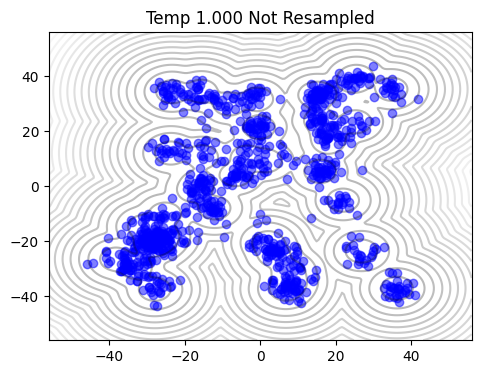

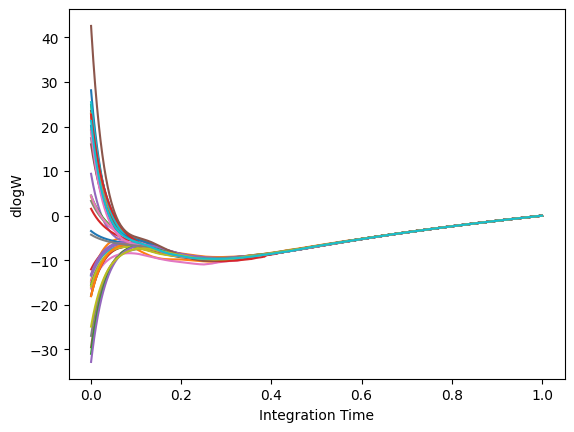

Mean of Energy tensor(-8.0618)


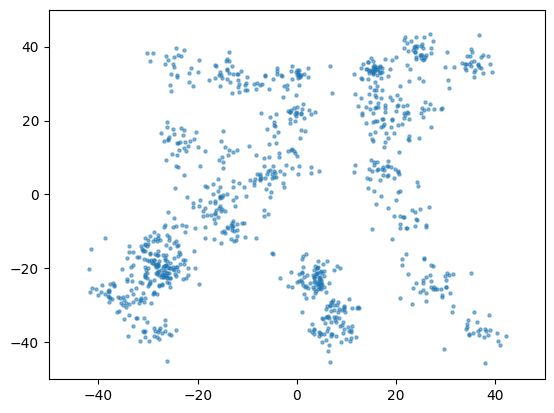

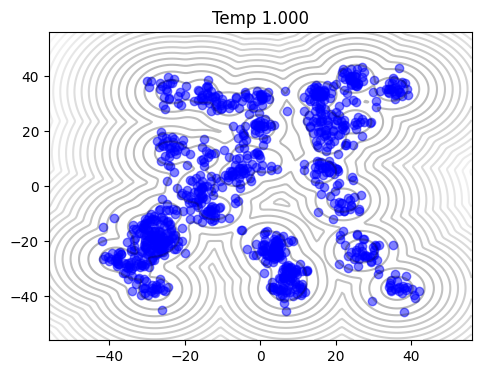

  1%|█▎                                                                                                                            | 1/100 [02:00<3:18:13, 120.14s/it]

hi
time:  tensor(1., grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.9000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.8000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.7000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.6000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.5000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.4010, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.3000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.2010, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.1010, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.0010, grad_fn=<SelectBackward0>) 0.0
not_resampled data
time:  tensor(1., grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.9000, grad_fn=<SelectBackward0>) 0.0
time:  tensor(0.8000, grad_fn=<SelectBackward0>) 0.0


  1%|█▎                                                                                                                            | 1/100 [02:27<4:03:55, 147.83s/it]


KeyboardInterrupt: 

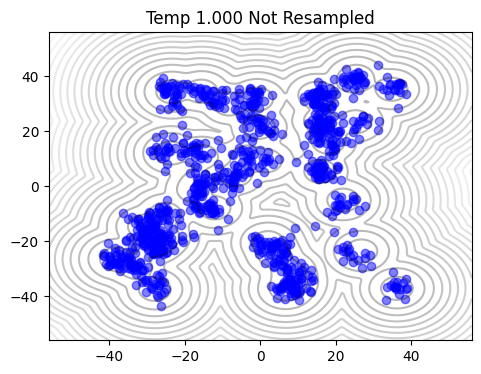

In [317]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        break
        total_loss = 0.0
        for beta in betas:
            for samples, _ in trainloader[beta]:
                samples = samples.to(device)

                optimizer.zero_grad()

                t = torch.rand(len(samples)).to(device)

                loss = score_loss(energy_net, samples, t, noise_schedule, beta)
                # loss = cfm_loss(model,
                #                 samples,
                #                 t,
                #                 beta)

                total_loss += loss.item()
                loss.backward()
                optimizer.step()

            if epoch % 99 == 0:
                print("Epoch %d | Loss %f" % (epoch, loss.item()))

    # Generate samples using the network
    print("hi")
    ve_reverse_sde = VEReverseSDE(energy_net, noise_schedule, score_model=energy_net)
    for beta in betas:
        samples_not_resampled, _ = generate_samples_weighted(
            ve_reverse_sde,
            prior=priors[beta],
            num_samples=1000,
            t_span=(0, 1),
            resampling_interval=-1,
            inverse_temp=beta,
            resample_at_end=False,
        )
        print("not_resampled data")
        target.get_dataset_fig(
            target.unnormalize(samples_not_resampled),
            title=f"Temp {1/beta:.3f} Not Resampled",
        )

        samples, _ = generate_samples_weighted(
            ve_reverse_sde,
            prior=priors[beta],
            num_samples=1000,
            t_span=(0, 1),
            resampling_interval=1,
            inverse_temp=beta,
            resample_at_end=False,
        )
        print("resampled_data")

        _, log_weights = generate_samples_weighted(
            ve_reverse_sde,
            prior=priors[beta],
            num_samples=1000,
            t_span=(0, 1),
            resampling_interval=2000,
            inverse_temp=beta,
            resample_at_end=False,
        )

        # new plot figure
        fig = plt.figure()
        plt.plot(torch.linspace(1, 0, 1000), log_weights.cpu().detach().numpy()[:, :40])
        plt.xlabel("Integration Time")
        plt.ylabel("dlogW")
        plt.show()
        samples_energy = target(samples)

        # Update Buffer
        buffer[beta].add(samples, samples_energy)

        print("Mean of Energy", samples_energy.mean())

        samples_unnorm = target.unnormalize(samples)
        plt.scatter(
            samples_unnorm[:, 0].detach().cpu(),
            samples_unnorm[:, 1].detach().cpu(),
            label="Samples",
            alpha=0.5,
            s=5,
        )
        plt.xlim(-50, 50)
        plt.ylim(-50, 50)
        plt.show()
        target.get_dataset_fig(samples_unnorm, title=f"Temp {1/beta:.3f}")
        plt.show()

        # Resample data from the buffer
        samples, samples_energy, _ = buffer[beta].sample(512 * 10)
        train_dataset = TensorDataset(samples, samples_energy)
        # trainloader[beta] = DataLoader(train_dataset, batch_size = 512, shuffle=True)